In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('politifact.csv')

Let's look at the label distribution for general case, and for some interesting sources like Donald Trump, Barack Obama or just Facebook posts.

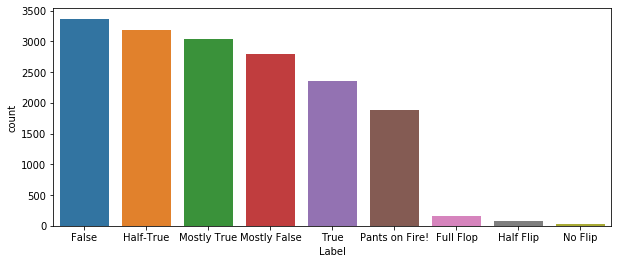

In [7]:
plt.figure(figsize=(10,4))
sns.countplot(df['Label'], order = df['Label'].value_counts().index);

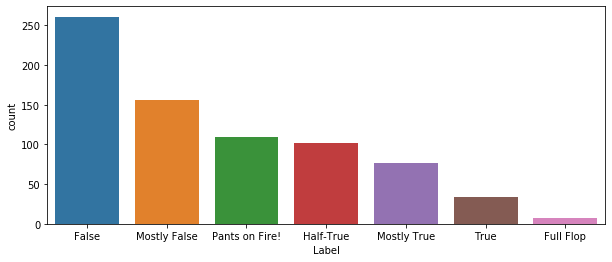

In [6]:
plt.figure(figsize=(10,4))
sns.countplot(df[df['Source']=='Donald Trump']['Label'], order = df[df['Source']=='Donald Trump']['Label'].value_counts().index);

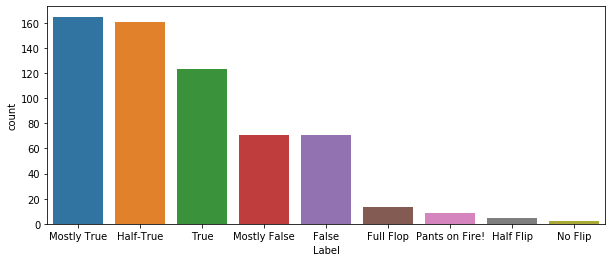

In [9]:
plt.figure(figsize=(10,4))
sns.countplot(df[df['Source']=='Barack Obama']['Label'], order = df[df['Source']=='Barack Obama']['Label'].value_counts().index);

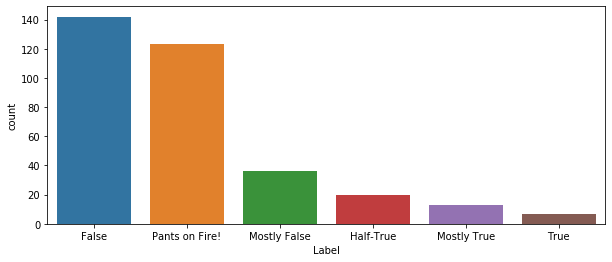

In [10]:
plt.figure(figsize=(10,4))
sns.countplot(df[df['Source']=='Facebook posts']['Label'], order = df[df['Source']=='Facebook posts']['Label'].value_counts().index);

Let's parse the date column as datetime:

In [20]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

Let's look at these 'flip' labels, they seem to be less relevant for the problem we are trying to solve.

In [22]:
df[df['Label']=='Full Flop']

,Unnamed: 0,Source,Text,Category,Date,Explanation,Label
311,311,Ghazala Hashmi,On whether Gov. Ralph Northam should resign.,Virginia,2019-10-15,Among many who changed on Northam,Full Flop
801,801,Kamala Harris,On the need for independent investigations of ...,California,2019-05-23,New stance is full reversal from past,Full Flop
980,980,Terry McAuliffe,On a bill that would have eased third-trimeste...,Virginia,2019-04-09,Took two opposite positions,Full Flop
1074,1074,Thom Tillis,Position on Trump’s national emergency declara...,North Carolina,2019-03-20,His actions don't match his op-ed,Full Flop
1141,1141,Tony Evers,On not pursuing higher taxes,Wisconsin,2019-03-05,Campaign Evers and governor Evers aren't on th...,Full Flop
...,...,...,...,...,...,...,...
16221,16221,Sarah Palin,On support for the Bridge to Nowhere.,National,2008-09-01,"As candidate, yes; as governor, no",Full Flop
16252,16252,Joe Biden,On whether he wants to be vice president.,National,2008-08-24,He seems interested,Full Flop
16288,16288,Barack Obama,On using the Strategic Petroleum Reserve.,National,2008-08-05,"Emergency now, but not then?",Full Flop
16294,16294,Barack Obama,On public financing of his campaign.,National,2008-08-04,"He said he'd pursue it, but opted out",Full Flop


In [24]:
len(df[df['Label'].str.contains('Fl')])

256

Indeed it is not about a specific statement being true or false but on whether a certain politician changed his view on a specific subject. This is useless for us, and it concerns a low minority of our dataset (256 lines over ~17K), let's drop those samples.

In [26]:
df.drop(df[df['Label'].str.contains('Fl')].index, axis=0, inplace=True)

In [27]:
len(df[df['Label'].str.contains('Fl')])

0

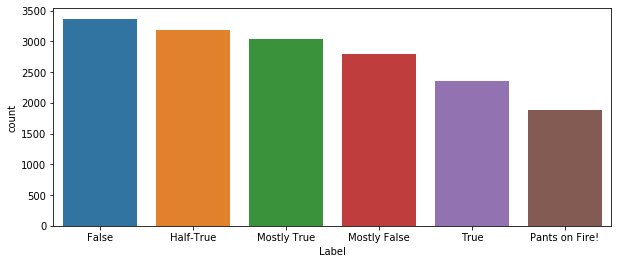

In [28]:
plt.figure(figsize=(10,4))
sns.countplot(df['Label'], order = df['Label'].value_counts().index);

The label is ordinal, so it's better to encode it and do regression, than building a classifier (since the classes are not independant). Let's encode our label in order to have a 'truth' score: positive for true statements and negative for false, so we can average on this score and get some interesting incentive of statements trends grouped by different features.

In [29]:
label_encode_dict = {'Pants on Fire!': -3, 'False': -2, 'Mostly False': -1, 'Half-True': 0 , 'Mostly True': 1, 'True': 2}

In [30]:
df['Label'] = df['Label'].map(label_encode_dict)

In [31]:
df['Label'].value_counts()

-2    3369
 0    3179
 1    3038
-1    2801
 2    2356
-3    1876
Name: Label, dtype: int64

In [32]:
df[df['Source']=='Donald Trump']['Label'].mean()

-1.1637347767253046

In [33]:
df[df['Source']=='Barack Obama']['Label'].mean()

0.285

As we could infer from the graphs, we can see that Trump has a strong tendency to lie/be wrong a lot whereas Obama is on average telling half-true to mostly true statements.

In [34]:
df[df['Source']=='Facebook posts']['Label'].mean()

-1.9413489736070382

Facebook is a highly unreliable source...

Let's see now if some days or period of the year are more prone to true/false statements (maybe around elections time...)

In [43]:
daily_mean = df[['Date','Label']].set_index('Date').resample('D').mean()

In [50]:
daily_mean.dropna(inplace=True)

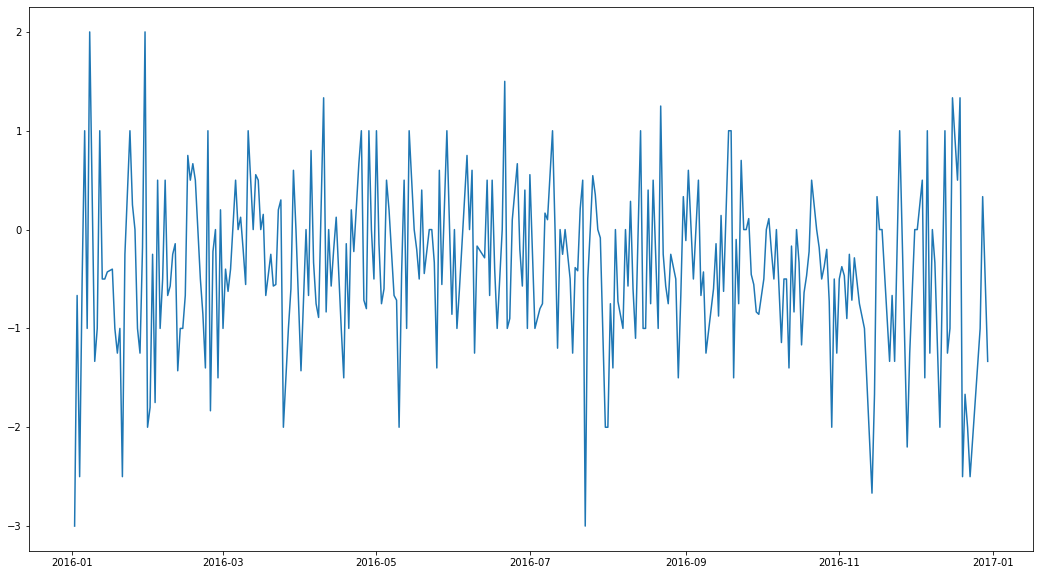

In [51]:
plt.figure(figsize=(18,10))
plt.plot(daily_mean.loc['2016-01-01':'2017-01-01'])

In [56]:
daily_mean['2016-07-10':'2016-07-31']

,Label
Date,
2016-07-10,1.000000
2016-07-11,0.000000
2016-07-12,-1.200000
2016-07-13,0.000000
2016-07-14,-0.250000
2016-07-15,0.000000
2016-07-17,-0.500000
2016-07-18,-1.250000
2016-07-19,-0.384615


In [52]:
monthly_mean = df[['Date','Label']].set_index('Date').resample('M').mean()

In [54]:
monthly_mean.dropna(inplace=True)

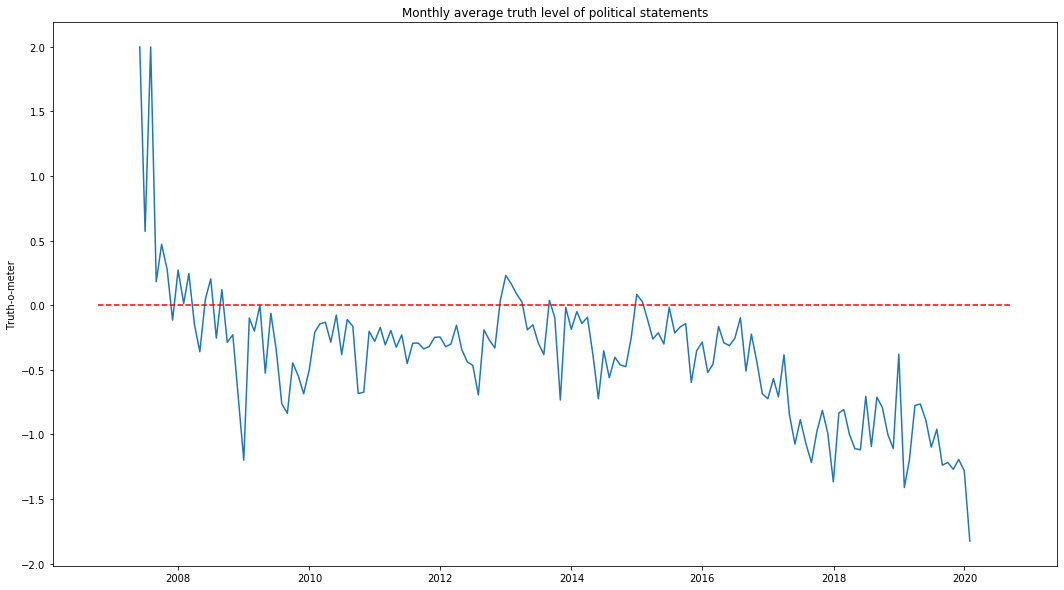

In [59]:
plt.figure(figsize=(18,10))
plt.plot(monthly_mean)
plt.title('Monthly average truth level of political statements')
plt.ylabel('Truth-o-meter')
left, right = plt.xlim()
plt.plot([left,right],[0,0],linestyle='--',c='r')

We can see that unfortunately on monthly average, we have a lot more false statements than in the past... And we can see a clear drop around beginning of 2017 (Trump's election...)

Let's split our data between train and test according to the date, taking 2019 as our test.

In [ ]:
df.set_index('Date', inplace=True)

In [67]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [68]:
df_test = df[:'2019-01-01']
df_train = df['2019-01-01':]

Let's encode the source's mean truth value as a new feature to help us predict, giving us 'source reliability', using only the train to calculate the mean. 

In [69]:
df_train

,Source,Text,Category,Explanation,Label
Date,,,,,
2018-12-27,Donald Trump,"Says troops recently received ""one of the bigg...",National,Not biggest ever; not first in 10 years,-3
2018-12-23,Garry McCarthy,"""There was almost a 70 percent reduction in po...",Illinois,"The numbers fell, but that doesn't mean he can...",0
2018-12-21,Dallas Woodhouse,"Says no elections protest was filed, McCready ...",North Carolina,But the claims don't necessarily matter,1
2018-12-21,Donald Trump,"""Russia, Iran, Syria & many others are not hap...",National,Putin says it's the right decision,-2
2018-12-20,Bloggers,"Quotes Winston Churchill as saying, ""When Musl...",Facebook fact-checks,No record of him ever saying that,-3
...,...,...,...,...,...
2007-06-12,Tom Tancredo,"""For every single scientist that tells you (gl...",National,Most scientists say humans cause warming,-2
2007-06-12,John Edwards,"""We now have the greatest income inequality si...",National,Economists find large income gap,2
2007-06-12,Bill Richardson,"""New Mexico was 46th in teacher pay (when he w...",National,"Correct, but stats came from friendly group",1


In [74]:
source_to_mean = dict(df_train.groupby('Source').Label.mean())

In [81]:
df_train['Source average reliability'] = df_train['Source'].map(source_to_mean)

/Users/Jonas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
df_train

,Source,Text,Category,Explanation,Label,Source average reliability
Date,,,,,,
2018-12-27,Donald Trump,"Says troops recently received ""one of the bigg...",National,Not biggest ever; not first in 10 years,-3,-1.122449
2018-12-23,Garry McCarthy,"""There was almost a 70 percent reduction in po...",Illinois,"The numbers fell, but that doesn't mean he can...",0,-1.000000
2018-12-21,Dallas Woodhouse,"Says no elections protest was filed, McCready ...",North Carolina,But the claims don't necessarily matter,1,1.000000
2018-12-21,Donald Trump,"""Russia, Iran, Syria & many others are not hap...",National,Putin says it's the right decision,-2,-1.122449
2018-12-20,Bloggers,"Quotes Winston Churchill as saying, ""When Musl...",Facebook fact-checks,No record of him ever saying that,-3,-2.356502
...,...,...,...,...,...,...
2007-06-12,Tom Tancredo,"""For every single scientist that tells you (gl...",National,Most scientists say humans cause warming,-2,-1.125000
2007-06-12,John Edwards,"""We now have the greatest income inequality si...",National,Economists find large income gap,2,0.333333
2007-06-12,Bill Richardson,"""New Mexico was 46th in teacher pay (when he w...",National,"Correct, but stats came from friendly group",1,0.235294


In [88]:
df_test['Source average reliability'] = df_test['Source'].map(source_to_mean)

/Users/Jonas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
